# Predicting customer satisfaction at Olist - a Brazilian e-commerce platform

## Modeling
Steps:

    - Preprocess data, split train & test sets, prepare the pipeline.
    - Test Logistic Regression & Randome Forest, tune hyperparameters with GridSearchCV & StratifiedKFold.
    - Select features & model, predict probability on test set.
    - Interpret business implication.

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

In [4]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

Load data

In [5]:
df = pd.read_csv(str(os.getcwd()) + '/' + 'final_df.csv')

In [6]:
print(df.shape)
print(df.columns)
df.head(3)

(97154, 33)
Index(['order_id', 'product_id', 'seller_id', 'price', 'freight_value',
       'customer_id', 'order_status', 'order_purchase_timestamp',
       'estimated_days_of_delivery', 'actual_days_of_delivery', 'year',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'product_category',
       'review_score', 'review_answer_delay', 'customer_zip_code_prefix',
       'state_code', 'customer_return', 'seller_zip_code_prefix',
       'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng',
       'state_name', 'avg_income', 'state_population', 'late_delivery'],
      dtype='object')


,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,estimated_days_of_delivery,actual_days_of_delivery,...,customer_return,seller_zip_code_prefix,customer_lat,customer_lng,seller_lat,seller_lng,state_name,avg_income,state_population,late_delivery
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13,16.0,7.0,...,0,27277,-21.758076,-41.312633,-22.498183,-44.123614,Rio de Janeiro,1537.216410,16718956,0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26,19.0,16.0,...,0,3471,-20.212393,-50.941471,-23.566258,-46.518417,São Paulo,1787.421374,45094866,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14,22.0,8.0,...,0,37564,-19.860439,-44.597972,-22.264094,-46.158564,Minas Gerais,1326.190434,21040662,0


### Data preprocessing:

In [7]:
def preprocessing(df):
    df['delivered'] = np.where(df['order_status']=='delivered', 1, 0)
    df['estimated_delivery_time_error'] = df['actual_days_of_delivery'] - df['estimated_days_of_delivery']
    
    # track review answer delay
    delay_bins = [-1, 0, 1, 2, 3, 518]
    delay_labels = ['0', '1', '2', '3', '3_plus']
    df['review_answer_delay_range'] = pd.cut(df['review_answer_delay'], delay_bins, labels=delay_labels)
    delay_dummies = pd.get_dummies(df['review_answer_delay_range'], prefix='review_delay_range')
    df = pd.concat([df, delay_dummies], axis=1)
    
    # create dummies for product category
    cat_dummies = pd.get_dummies(df['product_category'])
    df = pd.concat([df, cat_dummies], axis=1)
    
    # get purchase time
    df['purchase_month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.month
    df['purchase_day'] = pd.to_datetime(df['order_purchase_timestamp']).dt.day
    
    # drop unwanted columns
    to_drop = ['product_category', 'review_answer_delay_range', 'order_id', 'seller_id',
               'customer_id', 'product_id', 'state_code', 'order_status',
               'order_purchase_timestamp', 'year', 'review_answer_delay',
               'review_answer_delay_range', 'state_name']
    df = df.drop(columns=to_drop, axis=1)
    
    return df

Define predictors & target variable.

In [8]:
df_model = preprocessing(df)
X = df_model.drop(['review_score'], axis=1)
y = df_model['review_score']

The target variable is highly imbalanced, with the scores from 1 to 3 account for approx. 20% of the data set. We'll recategorize this variable into 2 main categoies: satisfied customers (review score 4 & 5) and unsatisfied customers (review scores from 1 to 3). This will help increase the representation of the minority classes, and help the models detect them better, while preserving the business insights and interpretability.

In [9]:
y2 = y.apply(lambda x: 0 if x in [1,2,3] else 1)

Split the train & test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y2,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)

In [11]:
print('Train set size: ', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Train set size:  (77723, 38) (77723,)
Test set size: (19431, 38) (19431,)


Prepare imputer & feature scaler

In [12]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

Class distribution in the training set, which will be similar in validation & test sets. This will be a baseline to evaluate our models' performance.

In [13]:
y_train.value_counts(normalize=True)

1    0.775729
0    0.224271
Name: review_score, dtype: float64

### Modeling
Metrics: 

    - Accuracy score.
    - The target variable is highly imbalance, however we value the predictions on both negative class (unhappy customers) and positive class (happy customers), we'll use F1 score as an additional metrics. This is the harmonic mean of precision score & recall score. 
    - Confusion matrix: to see the model performance on each class in more detail.

#### Logistic Regression
Hyperparameter tuning with GridSearchCV & PCA.

In [14]:
# model & pipeline for GridSearch
lr = LogisticRegression()

# add pca
pca = PCA()
n_components = list(range(25,X.shape[1],2))

# pipeline
pipe_lr = make_pipeline(imputer, scaler, pca, lr)

# hyper-parameters of the model that will be tested by GridSearchCV
parameters_lr = {
        'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 2],
        'logisticregression__penalty' : ['l2'],
        'logisticregression__solver' : ['newton-cg', 'sag', 'lbfgs'],
        'pca__n_components': n_components
        }

# define GridSearchCV
grid_lr = GridSearchCV(pipe_lr, 
                       param_grid=parameters_lr, 
                       cv=StratifiedKFold(),
                       verbose=1,
                      n_jobs=-1)

warnings. filterwarnings("ignore")
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  8.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1, 2],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['newton-cg', 'sag',
                                                        'lbfgs'],
                         'pca__n_components': [25, 27, 29, 31, 33, 35, 37]},
             verbose=1)

In [15]:
print('Best hyperparameters:\n{}'.format(grid_lr.best_params_))
print('Best estimator: ', grid_lr.best_estimator_)
print('Cross validation score: \n Accuracy:', grid_lr.best_score_)

Best hyperparameters:
{'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg', 'pca__n_components': 27}
Best estimator:  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=27)),
                ('logisticregression',
                 LogisticRegression(C=0.5, solver='newton-cg'))])
Cross validation score: 
 Accuracy: 0.8197959413235395


With the best parameters, we predict the outcome of the test set and calculate the score.

In [16]:
y_train_pred_lr = cross_val_predict(grid_lr.best_estimator_, X_train, y_train, cv=5, method='predict', n_jobs=-1)
print('Logistic Regression - best scores:')
print('F1-score:', f1_score(y_train, y_train_pred_lr))
print('Confusion matrix: \n', confusion_matrix(y_train, y_train_pred_lr))

Logistic Regression - best scores:
F1-score: 0.8937022813861355
Confusion matrix: 
 [[ 4839 12592]
 [ 1414 58878]]


#### Random Forest Classifier

Test with default settings to use as a baseline.

In [17]:
rf = RandomForestClassifier()
pipe_rf = make_pipeline(imputer, rf)

y_train_pred_rf = cross_val_predict(pipe_rf, X_train, y_train, cv=5, method='predict', n_jobs=-1)
print('RF CV score: \n Accuracy score:', accuracy_score(y_train, y_train_pred_rf))
print('F1-score:', f1_score(y_train, y_train_pred_rf))
print('Confusion matrix: \n', confusion_matrix(y_train, y_train_pred_rf))

RF CV score: 
 Accuracy score: 0.8216486754242631
F1-score: 0.894968934687074
Confusion matrix: 
 [[ 4802 12629]
 [ 1233 59059]]


Hyperparameter tuning:

    - To reduce the model complexity & bias: set max_features=0.5 & max_samples=0.5 - the model will use half the features and half the samples each time it builds a tree.
    - Tune max_depth & n_estimators.
    - Check train & test cv scores to detect overfitting.

In [18]:
rf1 = RandomForestClassifier(max_samples=0.5, max_features=0.5)

# pipeline
pipe_rf1 = make_pipeline(imputer, rf1)

# set hyperparameters to tune
params_rf1 = {'randomforestclassifier__n_estimators': [100,200,500,1000,1500],
              'randomforestclassifier__max_depth': [5,6,7,8,9,10,11,12]}

grid_rf1 = GridSearchCV(pipe_rf1, param_grid=params_rf1,
                        cv=StratifiedKFold(n_splits=3), scoring='f1',
                        verbose=1, n_jobs=-1,
                        return_train_score=True)

grid_rf1.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 100.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_features=0.5,
                                                               max_samples=0.5))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 6, 7, 8, 9,
                                                               10, 11, 12],
                         'randomforestclassifier__n_estimators': [100, 200, 500,
                                                                  1000, 1500]},
             return_train_score=True, scoring='f1', verbose=1)

In [19]:
print('Random Forest - GridSearchCV 1:')
print('Best params: ', grid_rf1.best_params_)
print('Best estimator: ', grid_rf1.best_estimator_)

Random Forest - GridSearchCV 1:
Best params:  {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 100}
Best estimator:  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, max_features=0.5,
                                        max_samples=0.5))])


Check train results to prevent overfitting:

In [20]:
grid_rf1_res = pd.DataFrame(grid_rf1.cv_results_)
grid_rf1_res.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,17.514557,0.223811,0.433382,0.012960,5,100,"{'randomforestclassifier__max_depth': 5, 'rand...",0.896107,0.895359,0.896056,0.895841,0.000341,39,0.896328,0.896674,0.896304,0.896435,0.000169
1,34.288680,0.271274,0.786572,0.011039,5,200,"{'randomforestclassifier__max_depth': 5, 'rand...",0.896138,0.895349,0.896161,0.895883,0.000377,38,0.896386,0.896527,0.896297,0.896403,0.000094
2,86.576355,1.323562,2.131561,0.324465,5,500,"{'randomforestclassifier__max_depth': 5, 'rand...",0.896243,0.895468,0.896270,0.895994,0.000372,17,0.896371,0.896677,0.896265,0.896438,0.000175


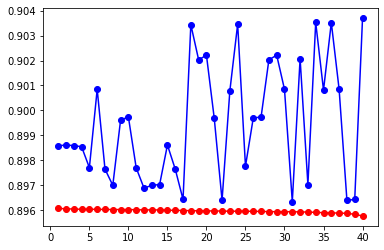

In [25]:
import matplotlib.pyplot as plt
grid_rf1_res.sort_values(by='rank_test_score', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(grid_rf1_res['rank_test_score'], grid_rf1_res['mean_train_score'], linestyle='-', marker='o', color='b')
ax.plot(grid_rf1_res['rank_test_score'], grid_rf1_res['mean_test_score'], linestyle='-', marker='o', color='r')
plt.show()

In [26]:
grid_rf1_res[['rank_test_score', 'param_randomforestclassifier__max_depth',
              'param_randomforestclassifier__n_estimators',
              'mean_train_score', 'mean_test_score']]

,rank_test_score,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,mean_train_score,mean_test_score
15,1,8,100,0.898590,0.896077
18,2,8,1000,0.898612,0.896063
19,3,8,1500,0.898595,0.896052
17,4,8,500,0.898547,0.896043
14,5,7,1500,0.897710,0.896042
29,6,10,1500,0.900847,0.896042
13,7,7,1000,0.897650,0.896036
8,8,6,1000,0.897003,0.896033
24,9,9,1500,0.899621,0.896031
20,10,9,100,0.899736,0.896031


The GridSearchCV results show that the more complex trees (max_depth at 10 or higher, number of trees at 1000 or 1500)  overfit the training set, hence higher training scores, but there's no improvement on the test set, meaning they can't generalize well on unseen data. In fact, the best estimator has 200 trees with max_depth at 7. This will save our computational cost significantly without trading off the model performance.

We'll get the model results using 5-fold cross_val_predict. This allows us to assemble predictions on all the test fold during cross validation & check the confusion matrix result.

In [27]:
rf1.set_params(**{'max_depth': 7, 'n_estimators': 200})
pipe_rf1_best = make_pipeline(imputer, rf1)
y_train_pred_rf1 = cross_val_predict(pipe_rf1_best, X_train, y_train, cv=5, method='predict', n_jobs=-1)
print('CV score: \n Accuracy score:', accuracy_score(y_train, y_train_pred_rf1))
print('F1-score:', f1_score(y_train, y_train_pred_rf1))
print('Confusion matrix: \n', confusion_matrix(y_train, y_train_pred_rf1))

CV score: 
 Accuracy score: 0.822742302793253
F1-score: 0.896057942585537
Confusion matrix: 
 [[ 4562 12869]
 [  908 59384]]


Now we'll increase max_samples & max_features to see if the model can yield better results.

In [28]:
rf2 = RandomForestClassifier(n_estimators=200,
                             max_depth=7)
# pipeline
pipe_rf2 = make_pipeline(imputer, rf2)

# set hyperparameters to tune
params_rf2 = {'randomforestclassifier__n_estimators': [200,500],
              'randomforestclassifier__max_samples': [0.5, 0.75],
              'randomforestclassifier__max_features': [0.5, 0.75]}

grid_rf2 = GridSearchCV(pipe_rf2, param_grid=params_rf2,
                        cv=StratifiedKFold(n_splits=3), scoring='f1',
                        verbose=1, n_jobs=-1,
                        return_train_score=True)

grid_rf2.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 12.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_depth=7,
                                                               n_estimators=200))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_features': [0.5, 0.75],
                         'randomforestclassifier__max_samples': [0.5, 0.75],
                         'randomforestclassifier__n_estimators': [200, 500]},
             return_train_score=True, scoring='f1', verbose=1)

In [29]:
print('Random Forest - GridSearchCV 2:')
print('Best params: ', grid_rf2.best_params_)
print('Best estimator: ', grid_rf2.best_estimator_)

Random Forest - GridSearchCV 2:
Best params:  {'randomforestclassifier__max_features': 0.75, 'randomforestclassifier__max_samples': 0.5, 'randomforestclassifier__n_estimators': 200}
Best estimator:  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=7, max_features=0.75,
                                        max_samples=0.5, n_estimators=200))])


In [30]:
pd.DataFrame(grid_rf2.cv_results_)[['rank_test_score', 'param_randomforestclassifier__n_estimators',
                                    'param_randomforestclassifier__max_features',
                                    'param_randomforestclassifier__max_samples', 'mean_test_score']]

,rank_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_features,param_randomforestclassifier__max_samples,mean_test_score
0,6,200,0.5,0.5,0.896094
1,5,500,0.5,0.5,0.896104
2,8,200,0.5,0.75,0.896027
3,7,500,0.5,0.75,0.896068
4,1,200,0.75,0.5,0.896170
5,4,500,0.75,0.5,0.896123
6,3,200,0.75,0.75,0.896153
7,2,500,0.75,0.75,0.896157


The cross validation score improves slightly but not significant. We'll finalize the hyperparameters and check the feature importances.

In [31]:
rf2.set_params(**{'max_features': 0.75, 'max_samples': 0.75})
pipe_rf2_best = make_pipeline(imputer, rf2)

Vizualizing feature importance for our analysis.

In [32]:
pipe_rf2_best.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=7, max_features=0.75,
                                        max_samples=0.75, n_estimators=200))])

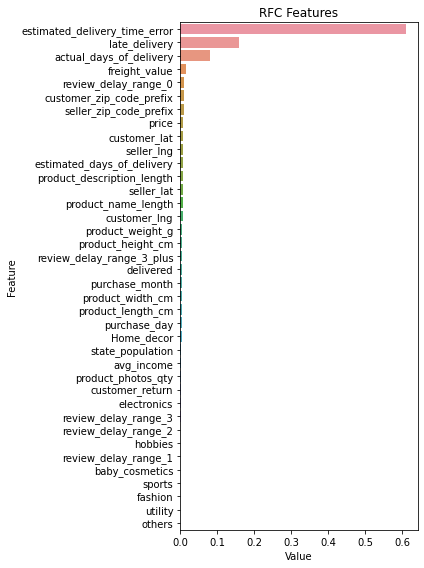

In [33]:
feature_imp_rf2 = pd.DataFrame(sorted(zip(pipe_rf2_best.named_steps['randomforestclassifier'].feature_importances_,
                                           X_train.columns)), columns=['Value','Feature'])
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 8))
sns.barplot(x='Value', y='Feature', data=feature_imp_rf2.sort_values(by='Value', ascending=False))
plt.title('RFC Features')
plt.tight_layout()
plt.show()

The 3 features with the largest effects are those concerning the delivery process: estimated_delivery_time_error, late_delivery & actual_days_of_delivery. This echoes with one of our first hypothesis about the effect of shipping time to customer satisfaction. Long and late deliveries dissatisfy online clients. 

Olist acts as an e-commerce platform connecting sellers and online shoppers, while providing logistic services. Ensuring excellent shipping services is one of the key factors to attract sellers and customers to the platform, and more importantly, keep the sellers stay and customers coming back. 

Delivery is processed through various steps, therefore is driven by many factors, such as stock management, order handling speed and transportation. As we don’t have detailed information about Olist internal operation, our suggestion is for the company to effectively track the shipping steps to get more accurate estimated delivery time, while detecting inefficient procedures to improve the overall shipping performance.

From the feature importance results, there are various insignificant features. We'll drop them to reduce noises & improve the model efficiency.

In [34]:
to_drop2 = ['delivered', 'product_photos_qty', 'customer_return', 'electronics',
           'review_delay_range_3', 'review_delay_range_1', 'hobbies',
           'review_delay_range_2', 'baby_cosmetics', 'fashion',
           'sports', 'utility', 'others']
X_train_new = X_train.drop(columns=to_drop2, axis=1)

In [35]:
pipe_rf2_best.fit(X_train_new, y_train)
y_train_pred_rf2 = cross_val_predict(pipe_rf2_best, X_train_new, y_train, cv=5, method='predict', n_jobs=-1)
print('RF2 best scores: \n Accuracy score:', accuracy_score(y_train, y_train_pred_rf2))
print('F1-score:', f1_score(y_train, y_train_pred_rf2))
print('Confusion matrix: \n', confusion_matrix(y_train, y_train_pred_rf2))

RF2 best scores: 
 Accuracy score: 0.8228452324279815
F1-score: 0.8961449399980389
Confusion matrix: 
 [[ 4549 12882]
 [  887 59405]]


#### Business implication

We'll use the best Random Forest model defined previously to predict probability of the test set, indicating the probability of each observation to belong to a certain class. This will be used to narrow down target customers, maximize the outcome of the company's business decisions within a limited budget.

In [36]:
X_test_new = X_test.drop(columns=to_drop2, axis=1)
y_test_proba = pd.DataFrame(pipe_rf2_best.predict_proba(X_test_new))
y_test_proba.head()

,0,1
0,0.913182,0.086818
1,0.193147,0.806853
2,0.194760,0.805240
3,0.156833,0.843167
4,0.293542,0.706458


##### Satisfied customers

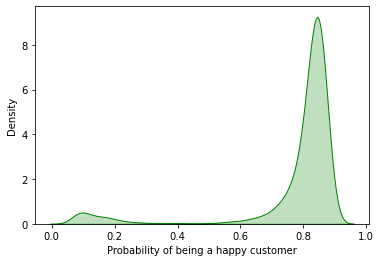

In [37]:
sns.kdeplot(data=y_test_proba, x=1, fill=True, color='g')
plt.xlabel('Probability of being a happy customer')
plt.show()

In [38]:
print('High probability of happy experience:', len(y_test_proba[y_test_proba[1] >= 0.75]), 'customers')
print('Percentage:', len(y_test_proba[y_test_proba[1] >= 0.75])*100 / len(y_test_proba))

High probability of happy experience: 16419 customers
Percentage: 84.49899644897329


One of the most important tasks of the project is to identify satisfied customers. Happy clients are more likely to come back. This is the customer group that Olist’s marketing strategy can target, for better outcome with less resources. Take chance to offer them membership program & premium shipping service, recommend products that align with their interest.The company can also study the happy customers’ habit, the popular product categories and reputable sellers to improve their recommender system.

##### Unsatisfied customers

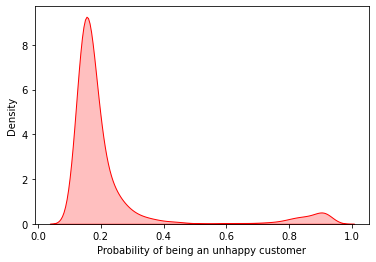

In [39]:
sns.kdeplot(data=y_test_proba, x=0, fill=True, color='red')
plt.xlabel('Probability of being an unhappy customer')
plt.show()

In [40]:
print('High probability of unhappy experience:', len(y_test_proba[y_test_proba[0] >= 0.75]), 'customers')
print('Percentage:', len(y_test_proba[y_test_proba[0] >= 0.75])*100 / len(y_test_proba))

High probability of unhappy experience: 1244 customers
Percentage: 6.402140908856981


We will select observations with highest probabilities of being in class 0 ( > 75%), referring to customers with highest chance of having a negative shopping experience. 

By detecting unhappy customers early, Olist can take chance to offer better customer services to these clients to compensate for their negative experience. Simple offers such as discount or free shipping fee on the next purchase would help repair the problem before a bad review is up on their website. The company can continue to expand their reputation, attract more sellers and new clients, while potentially keep the unhappy clients coming back.

-----
This is the end of our project sumary. Thank you very much for reading it. As always, any comments or feedbacks are more than welcome!